# Research Task - Statewide VRM/VRH by Operator per UZA [#1536](https://github.com/cal-itp/data-analyses/issues/1536)

**Task:**
<br>develop a statewide, analysis presented as a notebook, with an interactive map + a table of statewide VRH and VRM aggregated for each operator in each FTA UZA (and outside of those areas, in each RTPA or county).

**Metrics:** 
<br>total VRM and VRH in a UZA, percent of each metric that is provided by a given operator


**Expected Outputs / Findings:**
<br>notebook portfolio site with a map of all UZAs, with stats that pop up in the tooltip as one mouses over a UZA. Plus a table.

## Migrate initial statewide work from sjcog service anaylsis

In [8]:
import requests
import pandas as pd

import geopandas as gpd
import gcsfs
import google.auth

credentials, project = google.auth.default()
fs = gcsfs.GCSFileSystem(token=credentials)

## Latest Transit Service Intensity (TSI) data
should include operators

In [14]:
# tsi_agency = "gs://calitp-analytics-data/data-analyses/transit_service_intensity/test_tsi_agency_2025-04-16.parquet"
tsi_agency_2 = "gs://calitp-analytics-data/data-analyses/transit_service_intensity/test_tsi_agency_2025-07-16.parquet"

In [30]:
# read in parquet as gdf
tsi_data = gpd.read_parquet(
    tsi_agency_2,
    storage_options={"token": credentials.token},
)

In [31]:
tsi_data.head()

,tract,pop_sq_mi,population,geometry,schedule_gtfs_dataset_key,daily_vrm_miles,daily_vrh_hours
0,06001400100,1174.735672,3120,"POLYGON ((-197090.096 -12468.283, -196909.112 ...",a8d5f90bfd689badb7e1deb041408e96,179.5,2.9
1,06001400100,1174.735672,3120,"POLYGON ((-197090.096 -12468.283, -196909.112 ...",c499f905e33929a641f083dad55c521e,3.3,0.3
2,06001400200,8729.842564,2007,"POLYGON ((-196982.196 -15963.566, -196992.931 ...",8a1405af8da1379acc062e346187ac98,227.6,5.2
3,06001400200,8729.842564,2007,"POLYGON ((-196982.196 -15963.566, -196992.931 ...",c499f905e33929a641f083dad55c521e,388.7,37.7
4,06001400300,11819.185546,5051,"POLYGON ((-197350.929 -16712.642, -197950.200 ...",8a1405af8da1379acc062e346187ac98,227.6,5.2


<Axes: >

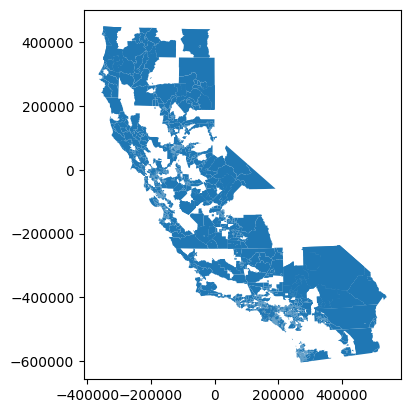

In [33]:
tsi_data.plot()

<Axes: >

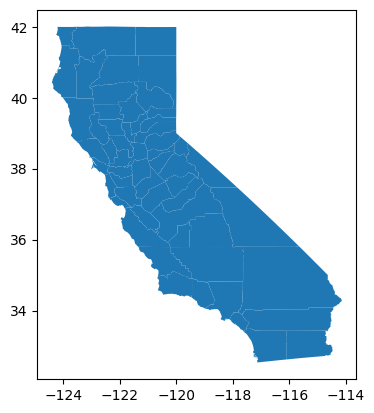

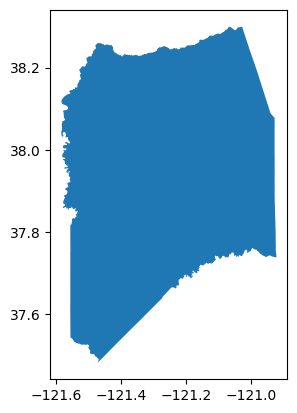

In [36]:
# CA Counties
county_url="https://caltrans-gis.dot.ca.gov/arcgis/rest/services/CHboundary/County_Boundaries/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

county_map=gpd.read_file(
    county_url,
    storage_options={"token": credentials.token}
)
county_map.plot()

# just San Joaquin
sj = county_map[county_map["NAME10"]=="San Joaquin"]
sj.plot()

<Axes: >

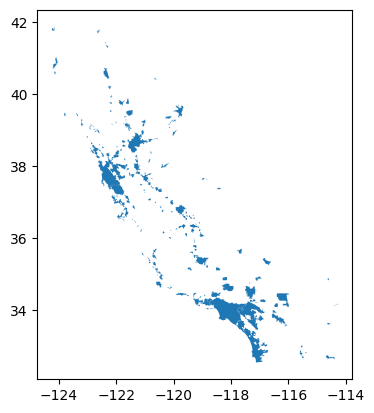

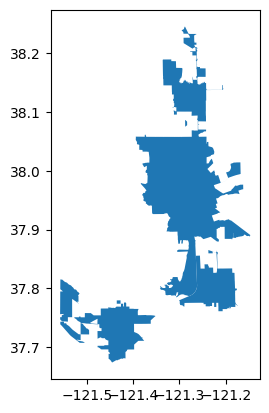

In [37]:
# UZA map
uza_url="https://caltrans-gis.dot.ca.gov/arcgis/rest/services/CHboundary/Adjusted_Urban_Area/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
uza_map=gpd.read_file(
    uza_url,
    storage_options={"token": credentials.token}
)

uza_map.plot()

# urban areas in San Joaquin coutny
uza_list =[
    "Stockton, CA",
    "Tracy--Mountain House, CA",
    "Manteca, CA",
    "Lodi, CA"
]

sj_uza= uza_map[uza_map["NAME"].isin(uza_list)]

sj_uza.plot()

In [38]:
uza_tsi_overlay = sj_uza.overlay(tsi_data.to_crs("EPSG:4326"),how='intersection')

<Axes: >

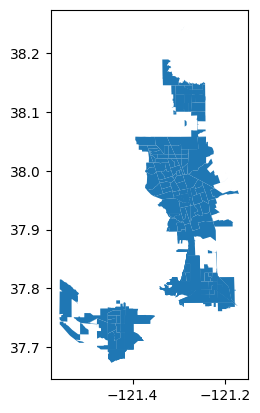

In [39]:
uza_tsi_overlay.plot()

## NTD STIC table

In [6]:
stic_url = "gs://calitp-analytics-data/data-analyses/ntd/service_analysis/FY-2025-5307-STIC-NTD-Data-09-01-2024.xlsx"

stic_data = pd.read_excel(
    stic_url,
    sheet_name="STIC by Agency",
    header=1,
    usecols=list(range(0,11))
)

In [7]:
display(
    stic_data.info(),
    stic_data.head(),
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UACE Code    938 non-null    float64
 1   UZA Name     939 non-null    object 
 2   Population   939 non-null    float64
 3   Density      939 non-null    float64
 4   NTD ID       612 non-null    float64
 5   Agency Name  924 non-null    object 
 6   PMT          925 non-null    float64
 7   VRM          925 non-null    float64
 8   VRH          925 non-null    float64
 9   UPT          925 non-null    float64
 10  VRM No SSW   925 non-null    float64
dtypes: float64(9), object(2)
memory usage: 80.9+ KB


None

,UACE Code,UZA Name,Population,Density,NTD ID,Agency Name,PMT,VRM,VRH,UPT,VRM No SSW
0,NaN,"AVERAGES - UZAs under 1 million and over 200,000",412547.646259,2383.217687,NaN,NaN,2.147983e+07,4.245097e+06,272383.92517,3.560950e+06,4.038872e+06
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,71060.0,"Port Charlotte-North Port, FL",199998.000000,1485.000000,40129.0,Charlotte County Government,4.124820e+05,3.096750e+05,20004.00000,4.643000e+04,3.096750e+05
3,71060.0,"Port Charlotte-North Port, FL",199998.000000,1485.000000,40046.0,Sarasota County,1.258899e+06,9.471430e+05,58420.00000,1.860080e+05,9.471430e+05
4,71060.0,"Port Charlotte-North Port, FL",199998.000000,1485.000000,NaN,UZA Total,1.671381e+06,1.256818e+06,78424.00000,2.324380e+05,1.256818e+06
